<a href="https://colab.research.google.com/github/evbevz/epoxy-supervisor/blob/main/EpoxyLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
    import google.colab
    IS_COLAB_ENV = True
except:
    IS_COLAB_ENV = False
if IS_COLAB_ENV:
    %pip install ultralytics
    !git clone https://github.com/evbevz/epoxy-supervisor.git
    dirBase = '/content/drive/MyDrive/Colab Notebooks/'

    from google.colab import drive
    drive.mount('/content/drive/')
else:
    dirBase = '/home/nikolay/opencv/'
%cd "{dirBase}epoxy-supervisor/"

In [2]:
import epoxylib
import os
from ultralytics import YOLO
from ultralytics import settings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Значение уверенности в правильности распознавания, ниже которого не будем считать, что точки определились правильно. Т.е. координаты такой точки будем считать ложными и точку игнорировать.
kptConfidence = 0.8 # Сейчас точки если и распознаются, то с уверенностью больше 0.9

# Калибровочный файл в котором хранятся уровни от 0 до 20мл. В виде координат X,Y центра эллипса поверхности эпоксидки на каждом уровне.
filenameAnnotation = f"{dirBase}epoxy-supervisor/samples/EpoxyLevelCalibrate.Rev.6.1.annotations.xml"

# Калибруем шприц
arrayEpoxyLevel = epoxylib.Calibrate(filenameAnnotation)

# Файл весов обученной для распознавания модели
#list_models = ["es.onepoint.yolo11s-pose.20250514.best.pt", "es.onepoint.yolo12s-pose.20250524.best.pt", "es.onepoint.yolo12s-pose.20250524.last.pt"]
#list_models = ["es.onepoint.yolo12s-pose.20250529.best.pt","es.onepoint.yolo12s-pose.20250529.last.pt"]
list_models = ["es.onepoint.yolo11s-pose.20250514.best.pt", "es.onepoint.yolo12s-pose.20250524.best.pt", "es.onepoint.yolo12s-pose.20250524.last.pt","es.onepoint.yolo12s-pose.20250529.best.pt","es.onepoint.yolo12s-pose.20250529.last.pt"]
list_levels = []
list_levels_pd = []

In [3]:
# Получаем сортированный список файлов
list_data_files=[]

#dirFrameset = "datasets/rev.6.1.p3/images/test"
#dirFramesetName = "rev.6.1.p3.test.20250529.onbigdataset"

#dirFrameset = "frameset-033"
#dirFramesetName = "frameset-033.20250529.onbigdataset"

#dirFrameset = "datasets/cam2.lvl3.one-point-ds/images/"
#dirFramesetName = "cam2.lvl3.one-point-ds.all.20250529.onbigdataset"

compareImageName = f"{dirFramesetName}.compare.png"
dataPath = f"{dirBase}epoxy-supervisor/{dirFrameset}"
for subdir, dirs, files in os.walk(dataPath):
    for file in files:
        list_data_files.append(os.path.join(subdir, file))        
list_data_files.sort(key = lambda x: x[-14:])
length_list_data_files = len(list_data_files)

In [4]:
#print(list_data_files)
#print(length_list_data_files)

In [5]:
# Предсказываем значения уровней для каждой модели
for filenameAIModel in list_models:
    fullfilenameAIModel = f"{dirBase}epoxy-supervisor/weights/{filenameAIModel}"
    print(fullfilenameAIModel)

    # Загружаем модель
    model = YOLO(fullfilenameAIModel)
   
    # Постороения списка уровней по изображениям в папке
    levels = []
    levels_pd = []
    index_with_none = []
    level = 20
    for i, file in tqdm(enumerate(list_data_files),total=length_list_data_files):
        level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, file , kptConfidence, level)
        levels.append(level)
        if level is not None:
            pass
            #print (f"Модель: {filenameAIModel}\tФайл: {file}\tУровень эпоксидки: {level:.2f}")
        else:
            index_with_none.append(i)
            print (f"Модель: {filenameAIModel}\tФайл: {file}\tУРОВЕНЬ ЭПОКСИДКИ: NONE !!!")

    # Показать был ли нераспознанный уровень эпоксидки и установить его в 0, если был.
    for i in index_with_none:
        print (f"Индекс: {i},\tФайл: {list_data_files[i]}\tУРОВЕНЬ ЭПОКСИДКИ: NONE !!!")
        levels[i] = 0
    length_index_with_none = len(index_with_none)
    print (f"Модель: {filenameAIModel}\tНераспознано кадров: {length_index_with_none}")
    
    # Сглаженные данные
    levels_pd = pd.Series(levels).rolling(window=50, center=True).mean()
    
    list_levels.append(levels)
    list_levels_pd.append(levels_pd)

/home/nikolay/opencv/epoxy-supervisor/weights/es.onepoint.yolo11s-pose.20250514.best.pt


  0%|          | 0/871 [00:00<?, ?it/s]

Модель: es.onepoint.yolo11s-pose.20250514.best.pt	Нераспознано кадров: 0
/home/nikolay/opencv/epoxy-supervisor/weights/es.onepoint.yolo12s-pose.20250524.best.pt


  0%|          | 0/871 [00:00<?, ?it/s]

Модель: es.onepoint.yolo12s-pose.20250524.best.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200003.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.best.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200016.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.best.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200033.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.best.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200035.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.best.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200066.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.best.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-l

  0%|          | 0/871 [00:00<?, ?it/s]

Модель: es.onepoint.yolo12s-pose.20250524.last.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200016.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.last.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200027.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.last.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200033.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.last.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200035.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.last.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-level-2-1140-new/images/val/00200051.png	УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Модель: es.onepoint.yolo12s-pose.20250524.last.pt	Файл: /home/nikolay/opencv/epoxy-supervisor/datasets/epoxy-l

  0%|          | 0/871 [00:00<?, ?it/s]

Модель: es.onepoint.yolo12s-pose.20250529.best.pt	Нераспознано кадров: 0
/home/nikolay/opencv/epoxy-supervisor/weights/es.onepoint.yolo12s-pose.20250529.last.pt


  0%|          | 0/871 [00:00<?, ?it/s]

Модель: es.onepoint.yolo12s-pose.20250529.last.pt	Нераспознано кадров: 0


Изображение сохранено с именем: epoxy-level-2-1140-new.all.20250529.onbigdataset.compare.png


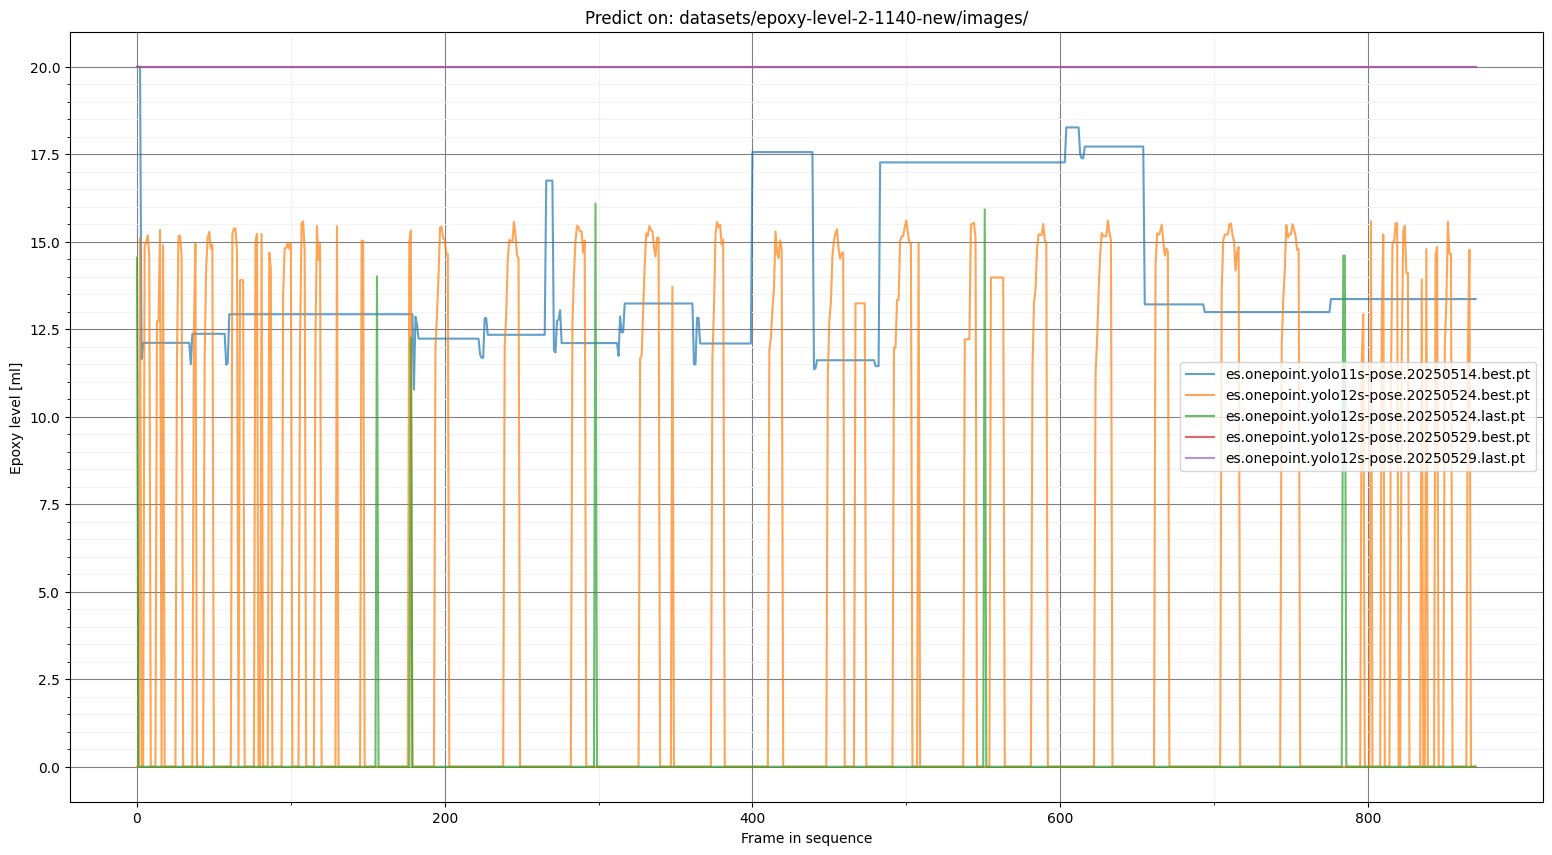

In [6]:
fig = plt.figure(figsize=(19, 10))
for i, filenameAIModel in enumerate(list_models):
    #print (f"i:{i}\tfilenameAIModel:{filenameAIModel}")
    plt.plot(list_levels[i], label=f"{filenameAIModel}", alpha=0.7)
    #plt.plot(list_levels_pd[i], label='Сглаженные данные')
    #plt.plot(delta, color='green', label='Разница от среднего')
plt.grid(axis='x', which='minor', color='0.95')
plt.grid(axis='x', which='major', color='0.5')
plt.xticks(np.arange(0, length_list_data_files, 100),minor='True')
plt.grid(axis='y', which='minor', color='0.95')
plt.grid(axis='y', which='major', color='0.5')
plt.yticks(np.arange(0, 20, 0.5),minor='True')
plt.legend()
#plt.show()
plt.title(f"Predict on: {dirFrameset}")
plt.ylabel('Epoxy level [ml]')
plt.xlabel('Frame in sequence')
plt.savefig(compareImageName)
print(f"Изображение сохранено с именем: {compareImageName}")